In [1]:
from typing import Dict, Optional, Tuple
from sympy import Ci
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import save_image, make_grid

from mindiffusion.unet import NaiveUnet
from mindiffusion.ddpm_guided import DDPM

import h5py
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import wandb

In [2]:
def curl_2d(field) -> np.ndarray:
    Fx_y = np.gradient(field[0], axis=1)
    Fy_x = np.gradient(field[1], axis=0)
    return Fy_x - Fx_y

def div_2d(field) -> np.ndarray:
    Fx_x = np.gradient(field[0], axis=0)
    Fy_y = np.gradient(field[1], axis=1)
    div = np.stack([Fx_x, Fy_y], axis=0)

    return div.sum(axis=0)

def div_torch(field):
    Fx_x = torch.gradient(field[0], dim=0)
    Fy_y = torch.gradient(field[1], dim=1)
    div = torch.stack([Fx_x[0], Fy_y[0]], dim=0)

    return torch.sum(div, dim=0)

def curl_torch(field):
    Fx_y = torch.gradient(field[0], dim = 1)
    Fy_x = torch.gradient(field[1], dim = 0)
    return Fy_x[0] - Fx_y[0]

def guidance(field):
    return torch.mean(torch.abs(div_torch(field)))

In [3]:
run = wandb.Api().run("dl4mag/mag-diffusion/te1nad15")
cfg = run.config
db = h5py.File(cfg["db"])
channels = db["field"].shape[1]
dbstd = np.std(db['field'])
ddpm = DDPM(eps_model=NaiveUnet(channels, channels, n_feat=cfg["features"]), betas=cfg["betas"], n_T=cfg["n_T"])
device = "cuda:1"
ddpm.load_state_dict(torch.load(f"./ddpm_magnet.pth", weights_only=True))
ddpm.to(device)
ddpm.eval()

DDPM(
  (eps_model): NaiveUnet(
    (init_conv): Conv3(
      (main): Sequential(
        (0): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
      )
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
        (5): ReLU()
      )
    )
    (down1): UnetDown(
      (model): Sequential(
        (0): Conv3(
          (main): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): GroupNorm(8, 128, eps=1e-05, affine=True)
            (2): ReLU()
          )
          (conv): Sequential(
            (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         

(30000, 2, 64, 64)
(30000,)
(30000,)
0.14926371
-0.0008631064


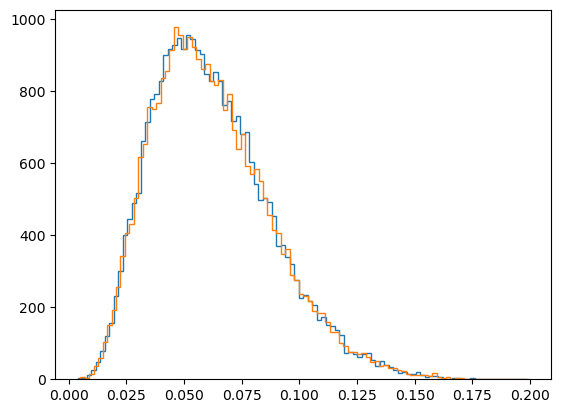

In [37]:
print(db["field"].shape)
xstds = np.array([np.std(field[0]) for field in db["field"]])
print(xstds.shape)
ystds = np.array([np.std(field[1]) for field in db["field"]])
print(ystds.shape)
xcounts, xbins = np.histogram(xstds, bins=100)
ycounts, ybins = np.histogram(ystds, bins=100)
plt.stairs(xcounts, xbins)
plt.stairs(ycounts, ybins)
print(np.std(db["field"][:,1]))
print(np.mean(db["field"][:,1]))

In [ ]:
stds = []:
    samples = 100
    xh = ddpm.sample(samples, (channels, 64, 64), device)
    fig, axes = plt.subplots(nrows=samples, ncols=channels, sharex=True,
                                            sharey=True, figsize=(8,8))

0.14939784
tensor(-8.3763, device='cuda:1')
tensor(7.3075, device='cuda:1')
tensor(2.5465, device='cuda:1')


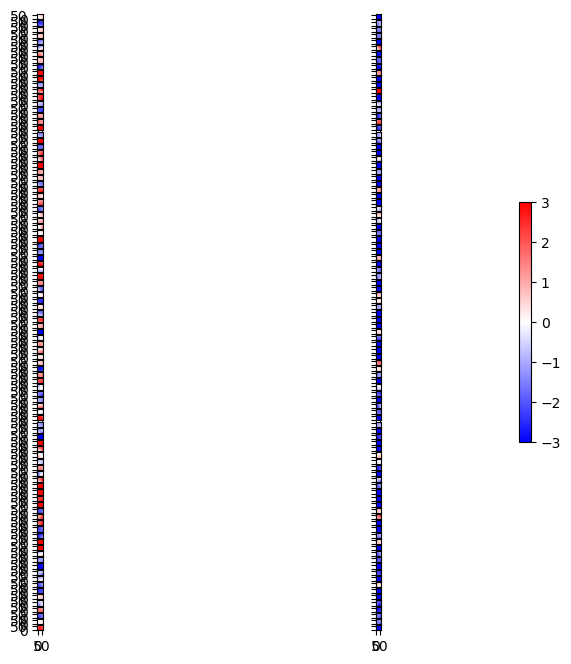

Div: 0.0033567906997632236 | Curl: 0.0033113163884263487


In [57]:
samples = 100
xh = ddpm.sample(samples, (channels, 64, 64), device)
fig, axes = plt.subplots(nrows=samples, ncols=channels, sharex=True,
                                        sharey=True, figsize=(8,8))
norm = colors.Normalize(vmin=-3, vmax=3)

print(dbstd)
print(torch.min(xh))
print(torch.max(xh))
print(torch.std(xh))

tot_curl = 0
tot_div = 0
for j, sam in enumerate(xh):
    #print(guidance(sam))
    sam_field = sam.cpu()
    tot_curl = tot_curl + abs(curl_2d(sam_field.numpy()*dbstd)).mean()
    tot_div = tot_div + abs(div_2d(sam_field.numpy())*dbstd).mean()

    for k, comp in enumerate(sam_field):
        #img = comp.permute(1,2,0)
        ax = axes.flat[j*channels+k]
        im = ax.imshow(comp.numpy(), cmap='bwr', norm=norm, origin="lower")

cbar_ax = fig.add_axes([0.9, 0.345, 0.015, 0.3])
fig.colorbar(im, cax=cbar_ax)
plt.show()
print(f"Div: {tot_div/samples} | Curl: {tot_curl/samples}")
plt.close()

In [79]:
print(torch.std(xh))
print(np.std(xh.cpu().numpy()))

tensor(2.5465, device='cuda:1')
2.5464966


In [80]:
magnetdb = h5py.File(cfg["db"])
dbstd = np.std(magnetdb['field'])
channels = magnetdb["field"].shape[1]

class MagnetismData(Dataset):
    def __init__(self, db, transform=None):
        self.db = db
        self.transform = transform

    def __len__(self):
        return self.db['field'].shape[0]

    def __getitem__(self, idx):
        field = self.db['field'][idx].transpose(1,2,0)
        #print(abs(div(self.db['field'][idx])).mean())
        if self.transform:
            field = self.transform(field)
        return field
    
tf = transforms.Compose([
    transforms.ToTensor()#, transforms.Normalize((0.0, )*channels, (dbstd, )*channels)
])

dataset = MagnetismData(
magnetdb,
transform=tf
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=1)

In [81]:
print(db["field"].shape)
div_test = div_torch(dataset[0])
#print(torch.linalg.norm(div_test))
#print(torch.norm(div_test)**2)
#print(torch.linalg.norm(div_test, 2)**2)
#print(torch.norm(div_test,2)**2)
#print(torch.sum(torch.pow(div_test,2)))
print(torch.mean(torch.abs(div_test)))
print(np.std(magnetdb["field"]/dbstd))
print(np.mean([np.std(img) for img in magnetdb["field"]]))
print(np.mean([torch.std(img) for img in dataset]))

(30000, 2, 64, 64)
tensor(7.1432e-06)
0.99999845
0.10528882
0.10529525
